# Image Classification

In [2]:
import pandas
import sklearn
import torch
import pandas as pd
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Train and test model

def train(network, device, train_loader, optimizer, epoch):
    running_loss = 0.0
    running_acc = 0.0
    train_losses = []
    train_acc=[]
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = network(data)
        output = F.log_softmax(output, -1)
        loss = F.nll_loss(output, target)
        new_target = F.one_hot(target, num_classes=output.shape[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += torch.sum(output == new_target)
    else:
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = running_acc/len(train_loader)*100
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print('Training loss: ' + str(epoch_loss))
        #torch.save(network.state_dict(), '/results/model.pth')
        #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
    '''if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( epoch, batch_idx * len(data), 
                                                                       len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), '/results/model.pth')
        torch.save(optimizer.state_dict(), '/results/optimizer.pth')'''
    return train_losses

def test(network, device, test_loader, epoch):
    test_losses=[]
    train_acc=[]
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            output = F.log_softmax(output, -1)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            test_acc =  100. * correct / len(test_loader.dataset)
        print('\nTest set: epoch: {:.4f}, Test set: Avg. loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(epoch, test_loss, test_acc))
    return test_losses, test_acc



In [3]:
# CNN model for grayscale image

class val_RNN(nn.Module):
    def __init__(self):
        super(val_RNN, self).__init__()

        self.hidden_dim = 64
        self.layer_dim=3
        self.input_dim=4
        self.output_dim = 1
        self.rnn = nn.RNN(
            self.input_dim, self.hidden_dim, self.layer_dim, batch_first = True
        )
        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim).requires_grad_()
        #x = torch.nn.Embedding(4, embedding_dim)
        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [4]:
# CNN model for grayscale image
class val_cnn_1D(nn.Module):
    def __init__(self):
        super(val_cnn_1D, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) #1, 10
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 20, kernel_size=5) #10, 20
        self.conv2_drop = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        

In [5]:
# CNN model for color image
class val_cnn_3D(nn.Module):
    def __init__(self):
        super(val_cnn_3D, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5) #1, 10
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) #10, 20
        self.conv2_drop = nn.Dropout2d(.25)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(5*5*50, 500)
        self.fc1_drop = nn.Dropout2d(.5)
        #self.fc2 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(1250, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 5*5*50)
        x = F.relu(self.fc1_drop(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [7]:
import math
# VGG Model
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [8]:
## Deprecated

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion *
                               out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [9]:
# Pretrained AlexNet Model
def alexnet():
    alex_model=models.alexnet(pretrained=True)
    for params in alex_model.features.parameters():
        params.requires_grad=False
    n_inputs = alex_model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, 10)
    alex_model.classifier[6] = last_layer
    return alex_model

In [10]:
# Evaluate MNIST model
def evaluate_image_model(train_img, test_img, lr, n_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #model= ResNet(ResidualBlock, [2, 2, 2]).to(device)
    model=val_cnn_1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.01)
    for epoch in range(1, n_epochs + 1):
        train_loss = train(model, device, train_img, optimizer, epoch)
        test_loss, test_acc = test(model, device, test_img, epoch)
        scheduler.step()

    return test_acc

In [11]:
# Classify the MNIST Dataset
from sklearn.model_selection import train_test_split
n_epochs = 3
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Load MNIST dataset
dftransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_ds = datasets.MNIST(root = './data', train=True, download=True, transform=dftransform)
train_data = DataLoader(dataset=train_ds, batch_size=batch_size_train, shuffle=True)
test_ds = datasets.MNIST(root = './data', train=False, download=True, transform=dftransform)
test_data = DataLoader(dataset=train_ds, batch_size=batch_size_train, shuffle=True)
dataiter=iter(train_data)
#images, labels = dataiter.next()
test_a = evaluate_image_model(train_data, test_data, learning_rate, n_epochs)
test_a

Training loss: 0.5720676169544459


D:\projects\venv310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: epoch: 1.0000, Test set: Avg. loss: 0.0003, Accuracy: (96%)

Training loss: 0.292133841154476

Test set: epoch: 2.0000, Test set: Avg. loss: 0.0001, Accuracy: (97%)

Training loss: 0.2560045347983638

Test set: epoch: 3.0000, Test set: Avg. loss: 0.0002, Accuracy: (97%)



tensor(97.0617, device='cuda:0')

In [12]:
def evaluate_image_model2(train_img, test_img, lr, n_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #model= ResNet(ResidualBlock, [2, 2, 2]).to(device)
    model=ResNet18().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)#, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.01)
    for epoch in range(1, n_epochs + 1):
        train_loss = train(model, device, train_img, optimizer, epoch)
        test_loss, test_acc = test(model, device, test_img, epoch)
        scheduler.step()

    return test_acc

In [13]:
# Classify the CIFAR10 datset
from sklearn.model_selection import train_test_split
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
n_epochs = 3
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
# Load 3D color pictures
#dftransform = transforms.Compose([transforms.Resize(256), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dftransform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_ds = datasets.CIFAR10(root = './data', train=True, download=True, transform=dftransform)
train_data = DataLoader(dataset=train_ds, batch_size=batch_size_train, shuffle=True)
test_ds = datasets.CIFAR10(root = './data', train=False, download=True, transform=dftransform)
test_data = DataLoader(dataset=test_ds, batch_size=batch_size_train, shuffle=False)
dataiter=iter(train_data)
#images, labels = dataiter.next()
test_a = evaluate_image_model2(train_data, test_data, learning_rate, n_epochs)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:33<00:00, 5029947.80it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training loss: 1.7320549535751342

Test set: epoch: 1.0000, Test set: Avg. loss: 0.0132, Accuracy: (52%)

Training loss: 1.2199672080278396

Test set: epoch: 2.0000, Test set: Avg. loss: 0.0121, Accuracy: (57%)

Training loss: 1.1827590157985688

Test set: epoch: 3.0000, Test set: Avg. loss: 0.0121, Accuracy: (57%)



# Variational Autoencoder

In [40]:
features = 10
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim=latent_dim
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
        )

         # Latent space
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        
    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

In [47]:
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def train_vae(network, device, train_loader, optimizer, criterion, num_epoch):
    running_loss = 0.0
    train_losses = []  # List to store training losses
    network.train()
    network.to(device)
    for epoch in range(num_epoch):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            reconstruction, mu, logvar = network(data)
            recon_loss = criterion(reconstruction, data)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_divergence  # Fix the variable name here
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate and store the average loss for this epoch
        average_loss = running_loss / len(train_loader)
        train_losses.append(average_loss)
        
        # Print or log the average loss for this epoch
        print(f"Epoch [{epoch + 1}/{num_epoch}], Loss: {average_loss}")
    
    return train_losses

def test_vae(network, device, test_loader, criterion, epoch):
    running_loss = 0.0
    test_losses=[]
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            
            reconstruction, mu, logvar = network(data)
            recon_loss = criterion(reconstruction, data)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_divergence  # Fix the variable name here
            test_loss += loss.item()/len(test_loader.dataset)
            test_losses.append(test_loss)
    #print('\nTest set: epoch: {:.4f}, Test set: Avg. loss: {:.4f}\n'.format(epoch, test_losses))
    return test_losses



In [48]:
# Evaluate MNIST model
def evaluate_image_vae(train_img, test_img, lr, n_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #model= ResNet(ResidualBlock, [2, 2, 2]).to(device)
    model=Autoencoder(latent_dim=20).to(device)
    criterion = nn.BCELoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.01)
    for epoch in range(1, n_epochs + 1):
        train_loss = train_vae(model, device, train_img, optimizer, criterion, epoch)
        test_loss = test_vae(model, device, test_img, criterion, epoch)
        scheduler.step()

    return test_loss

In [53]:
# Variational Auotencoder for MNIST dataset
from sklearn.model_selection import train_test_split
n_epochs = 6
batch_size_train = 16
batch_size_test = 16
learning_rate = 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Load MNIST dataset
dftransform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root = './data', train=True, download=True, transform=dftransform)
train_data = DataLoader(dataset=train_ds, batch_size=batch_size_train, shuffle=True)
test_ds = datasets.MNIST(root = './data', train=False, download=True, transform=dftransform)
test_data = DataLoader(dataset=train_ds, batch_size=batch_size_train, shuffle=True)
dataiter=iter(train_data)
#images, labels = dataiter.next()
evaluate_image_vae(train_data, test_data, learning_rate, n_epochs)



Epoch [1/1], Loss: 1989.8691588216145
Epoch [1/2], Loss: 1707.826653548177
Epoch [2/2], Loss: 3408.433492220052
Epoch [1/3], Loss: 1698.3218564453125
Epoch [2/3], Loss: 3396.879433496094
Epoch [3/3], Loss: 5095.0545557942705
Epoch [1/4], Loss: 1697.62401328125
Epoch [2/4], Loss: 3395.4253091471355
Epoch [3/4], Loss: 5093.590147070313
Epoch [4/4], Loss: 6790.840770540364
Epoch [1/5], Loss: 1698.1839537434896
Epoch [2/5], Loss: 3396.2427970703125
Epoch [3/5], Loss: 5094.323473209635
Epoch [4/5], Loss: 6792.784308756511
Epoch [5/5], Loss: 8491.330126725261
Epoch [1/6], Loss: 1698.5748372395833
Epoch [2/6], Loss: 3396.4129926757814
Epoch [3/6], Loss: 5094.139583951823
Epoch [4/6], Loss: 6792.162475097656
Epoch [5/6], Loss: 8490.09072858073
Epoch [6/6], Loss: 10188.09136998698


[0.029679518636067707,
 0.060531496175130206,
 0.08721263020833334,
 0.11495152180989583,
 0.1414041951497396,
 0.17236954142252606,
 0.204173964436849,
 0.2321635192871094,
 0.2582008809407552,
 0.2863947001139323,
 0.31407214762369795,
 0.34502276204427085,
 0.3741700988769531,
 0.4014546447753906,
 0.43134164835611977,
 0.45914904378255206,
 0.4877510009765625,
 0.5157864135742187,
 0.5438440104166666,
 0.5717851440429688,
 0.5996720947265625,
 0.6270900533040364,
 0.6559833638509115,
 0.6854541605631511,
 0.7150598999023439,
 0.7462237691243491,
 0.7738773742675782,
 0.8017446879069011,
 0.8287548502604167,
 0.8548897928873699,
 0.8834276875813803,
 0.9114030415852866,
 0.9418385559082033,
 0.9704130818684897,
 0.9975747009277345,
 1.0246522603352866,
 1.0550422668457031,
 1.0853271748860678,
 1.112150958251953,
 1.1411347045898437,
 1.1684435506184896,
 1.1969487386067708,
 1.226421203613281,
 1.2532143697102862,
 1.2809041076660155,
 1.3082968261718748,
 1.3374309814453123,
 1.36

# Neural Style Transfer

In [3]:
import cv2
import pandas
import sklearn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import PIL.Image as Image
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import numpy as np

D:\projects\venv310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\projects\venv310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████| 6000/6000 [25:28<00:00,  4.03it/s]

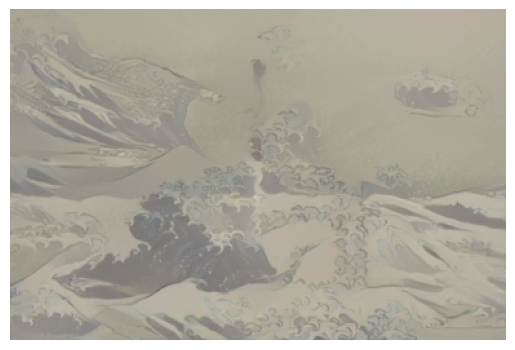

100%|███████████████████████████████████████████████████████████| 6000/6000 [25:29<00:00,  3.92it/s]


In [4]:
def load_img(img_path, shape=None):
    image = Image.open(img_path).convert("RGB") 
    max_size = 256
    
    if max(image.size) > max_size:
        size=max_size
    else:
        size = max(image.size)
    new_size = size
    if shape is not None:
        new_size = shape
    dftransform = transforms.Compose([transforms.Resize(new_size), 
                                      transforms.ToTensor()])
    image = dftransform(image).unsqueeze(0)
    image.requires_grad = True
    return image

def im_convert(tensor):
    """Convert a PyTorch tensor to a NumPy image."""
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze(0)  # Remove batch dimension
    image = image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1] in case of over- or underflow
    return image

def val_content_loss(target, content):
    return torch.mean((target - content) ** 2)

def val_vgg19():
    vgg_model=models.vgg19(pretrained=True).features
    for params in vgg_model.parameters():
        params.requires_grad=False
    return vgg_model

def get_features(image, model, device=None, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    if device is None:
        device = next(model.parameters()).device  # Get the device of the model's parameters
    features = {}
    x = image.to(device)
    for name, layer in enumerate(model):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features


def gram_matrix(img):
    _, d, h, w = img.size()
    img = img.view(d, h*w)
    gram = torch.mm(img, img.T)
    return gram



def train_ns(content_image, style_image, model, lr=0.01, capture_frame=100):
    style_weights = {'conv1_1': 1,
                     'conv2_1': 0.7,
                     'conv3_1': 0.2,
                     'conv4_1': 0.2,
                     'conv4_2': 0.2,
                     'conv5_1': 0.2}
    content_weight = 1
    style_weight = 1e6
    content_features = get_features(content_image.to(device), model)
    target_image = content_image.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([target_image], lr=0.01)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.01)
    steps = 6000
    counter = 0
    image_array = []

    style_features = get_features(style_image.to(device), model)
    style_gram = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    # Enable anomaly detection
    torch.autograd.set_detect_anomaly(True)

    pbar = tqdm(total=steps, ncols=100)  # Create a tqdm progress bar
    
    for ii in range(1, steps + 1):
        target_features = get_features(target_image, model)
        content_loss = val_content_loss(target_features['conv4_2'], content_features['conv4_2'])
        style_loss = 0

        for layer in style_weights:
            style_loss = style_loss +torch.mean((gram_matrix(target_features[layer]) - style_gram[layer]) ** 2)

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        optimizer.step()
        pbar.update(1)  # Update the tqdm progress bar
        if ii % capture_frame == 0:
            # You should define and implement im_convert() to convert the tensor back to an image
            gen_im = im_convert(target_image)
            image_array.append(gen_im)
            counter = counter+ 1
            # Display the generated image
            if ii == steps:
                plt.figure()
                plt.imshow(gen_im)
                plt.axis('off')
                plt.show()
                plt.imsave("kanagawa_starlink.jpg", gen_im)


    pbar.close()  # Close the tqdm progress bar

    return image_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content_path = 'C:/Users/vtoci/Documents/f9starlink41.png' #f.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = 'C:/Users/vtoci/Documents/Kanagawa.png' #tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_image = load_img(content_path)
style_image = load_img(style_path, shape=content_image.shape[-2:])
model=val_vgg19().to(device)
style_array=train_ns(content_image, style_image, model)


Basics

In [28]:
import numpy as np
 
polynomial = np.poly1d([1, 2, 3])
print(polynomial)
X = np.random.randn(20,1) * 5
x = torch.tensor([1., 2., 3.], requires_grad=True) #Make it variable
x = torch.tensor(3.6, requires_grad=True)
y = x * x
y.backward() #d(x^2)/dx = 2*x
print(x.grad), print(polynomial(x.detach().numpy())), print(polynomial(X))

XX = np.hstack([X*X, X, np.ones_like(X)])
 
w = torch.randn(3, 1, requires_grad=True)  # the 3 coefficients
x = torch.tensor(XX, dtype=torch.float32)  # input sample
optimizer = torch.optim.NAdam([w], lr=0.01)
y1=y.detach()
for _ in range(1000):
    optimizer.zero_grad()
    y_pred= x@w
    mse=torch.mean(torch.square(y1-y_pred))
    mse.backward()
    optimizer.step()

w

   2
1 x + 2 x + 3
tensor(7.2000)
23.159999122619638
[[  4.63350238]
 [ 16.06796656]
 [ 58.51310083]
 [ 33.35171631]
 [  6.36745835]
 [ 16.67055802]
 [ 57.49447396]
 [ 60.11065806]
 [ 32.38450341]
 [136.22714198]
 [ 12.19026404]
 [ 54.46424611]
 [ 13.56614336]
 [  2.4421323 ]
 [ 42.04235575]
 [ 45.61030489]
 [ 59.18276922]
 [ 10.80423649]
 [  2.24466081]
 [  2.31652481]]


tensor([[ 0.0919],
        [-0.0725],
        [ 7.9713]], requires_grad=True)

In [31]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

data = fetch_california_housing()
X, y = data.data, data.target
n_epochs=10
batch_size=32

 
# train-test split for model evaluation
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

x_train = torch.tensor(X_train, dtype=torch.float32)
x_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).reshape(-1, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float32).reshape(-1, 1)

model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6,1)
)
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_start=torch.arange(0, len(x_train), batch_size)

train_mse_history=[]
test_mse_history=[]

for epoch in range(n_epochs):
    model.train()
    epoch_mse=[]
    for start in batch_start:
        x_batch=x_train[start:start+batch_size]
        y_batch=torch.tensor(Y_train[start:start+batch_size], dtype=torch.float32)
        y_pred=model(x_batch).squeeze(1)
        loss=loss_fn(y_pred, y_batch)
        epoch_mse.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_epoch = sum(epoch_mse)/len(epoch_mse)
    train_mse_history.append(train_epoch)

    model.eval()
    epoch_test=[]
    with torch.no_grad():
        y_pred=model(x_test)
        Y_test=torch.tensor(Y_test, dtype=torch.float32)
        test_loss=loss_fn(y_pred, Y_test)
        test_mse_history.append(float(test_loss))
train_mse_history, test_mse_history

C:\Users\vtoci\AppData\Local\Temp\ipykernel_29256\1202245751.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch=torch.tensor(Y_train[start:start+batch_size], dtype=torch.float32)
D:\projects\venv310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\projects\venv310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target,

([1.978824749720835,
  1.3607656114396796,
  1.3377235130926148,
  1.3323987630088772,
  1.3308894709411976,
  1.3304394730160722,
  1.330126144717225,
  1.3299866625956729,
  1.3298089338087402,
  1.3297336009223903],
 [1.3420192003250122,
  1.2921301126480103,
  1.2790248394012451,
  1.2753164768218994,
  1.2745895385742188,
  1.2742637395858765,
  1.274024248123169,
  1.2747631072998047,
  1.2743264436721802,
  1.2741875648498535])

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

class SonarModel(nn.Module):
    def __init__(self):
        super(SonarModel, self).__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

sonar_data = pd.read_csv('sonar_csv.csv')
X_train, X_test, Y_train, Y_test = train_test_split(sonar_data.iloc[:, 0:60], sonar_data.iloc[:, 60], train_size=0.7, shuffle=True, stratify=sonar_data.iloc[:, 60])
encoder = LabelEncoder()
encoder.fit(Y_train)
y_train = encoder.transform(Y_train)
y_test = encoder.transform(Y_test)
X_train = X_train.to_numpy(dtype=np.float32)
X_test = X_test.to_numpy(dtype=np.float32)
loader = DataLoader(list(zip(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1))), shuffle=True, batch_size=16)

loss_fn=nn.BCELoss()
optimizer=optim.SGD(model.parameters(), lr=0.1, momentum=0.8)

n_epochs=300
model = SonarModel()
model.train()
for epoch in range(n_epochs):
    for x_batch, y_batch in loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
acc=0
model.eval()
y_pred = model(torch.tensor(X_test, dtype=torch.float32))
acc = float((y_pred.round()==torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)).float().mean())
acc

0.460317462682724